# MCF Rab5a Example
Ziyad Rahman

This is just a "proof of concept" so you understand where I'm at with this project. I've rewritten almost everything to streamline code readability.

I'll walk through each step in detail, so you understand what's happening. Some of this might be obvious, but I just want to write it down so at the very least you can go "okay, so it works the same way in Python".

Sorry if some of this is a little disjointed. I'm writing and rewriting this as I'm updating the methods and function (this is a really helpful way to build out the project).

## Imports
We'll just start by importing the modules I made. To make it user friendly, all the complicated code is actually contained in the files under the `src` folder.

In [3]:
# imports
import sys, os
sys.path.append(os.path.abspath(".."))
from src import *

# ignore this, this is just for you to see the graphs
%matplotlib inline

f_path = 'example_images/20220929_MCF_Rab5a_WH_heterotypic_s1_SCALED.tif' # just the path to the Tiff

## Getting the TIFF File
Now, we'll use the module I created to get the Tiff file

In [4]:
img = TiffStack(f_path, "Rab5a") 
arr = img.arr
arr.shape

(96, 3, 520, 2329)

The `df` variable is basically just a 4D array. It's the data structure we use to interact with the Tiff file. Literally all it is is a 4D array, where every value is between 0-32768 representing how bright or dark a pixel is.

When we get the shape of the array (like how a 3x4 matrix is 3 rows, 4 columns), we get `(96, 3, 520, 2329)`, which is just (Frames, Channels, Frame Height, Frame Width). Using ImageJ, we can see this exactly matches what we expect. That is, ImageJ shows us that this particular Tiff file has 96 frames over 3 channels, where each frame is 520 by 2329 pixels.

Just for peace of mind, let's figuring out which channel is which. ImageJ will showed these colored, but I've grey-scaled them because it was a) easier to do and b) the Python libraries work better on grey images.

Below is an example comparing the first frame of each channel. I do have a way to play the full Tiff stack video, but there's no great way to put it into Github (that I know of).

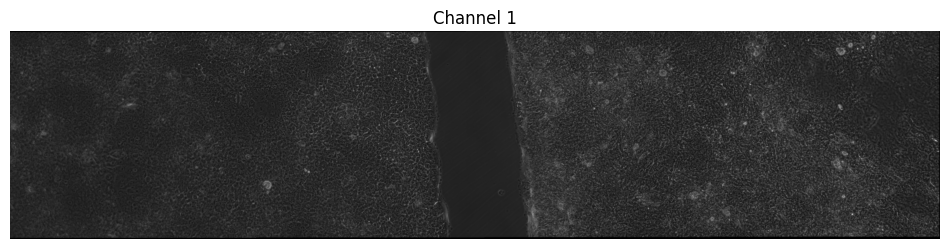

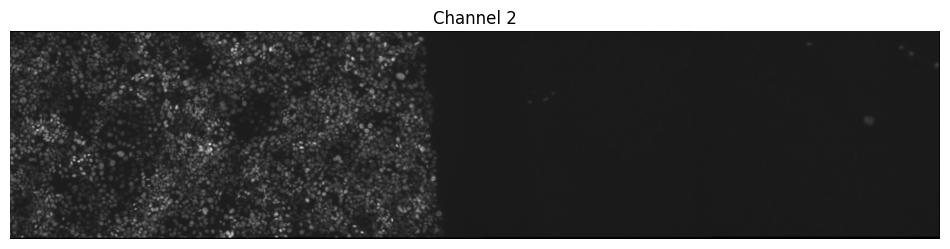

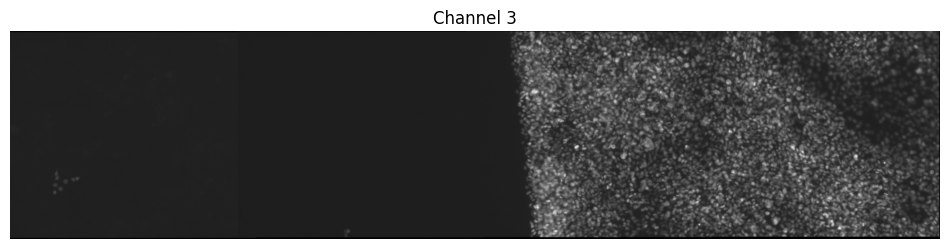

In [5]:
f1c1 = img.isolate_channel(0)[0] # isolate the first frame of channel 1; Python indexing starts at 0, so channel 1 is index 0
f1c2 = img.isolate_channel(1)[0] # isolate the first frame of channel 2
f1c3 = img.isolate_channel(2)[0] # isolate the first frame of channel 3

show_image(f1c1, title='Channel 1')
show_image(f1c2, title='Channel 2')
show_image(f1c3, title='Channel 3')

## Comments on Optical Flow Preprocessing
I'm not going to go super in-depth on the preprocessing stage in this notebook. It is much easier to talk about in person. Basically,
I'm going to take channels 2 and 3 and apply apply various blurs to the image. The result is an image where the cells look a lot more round. I found that it made the optical flow program much more accurate.

This was the key fix from last time I showed you the program. The actual optical flow algorithm is exactly the same, but I've changed how I've preprocessed the images to make them easier for the algorithm.

Below is an example with the first frame of channel 2. I also included an example of channel 1 to show that this method does not work with that channel.

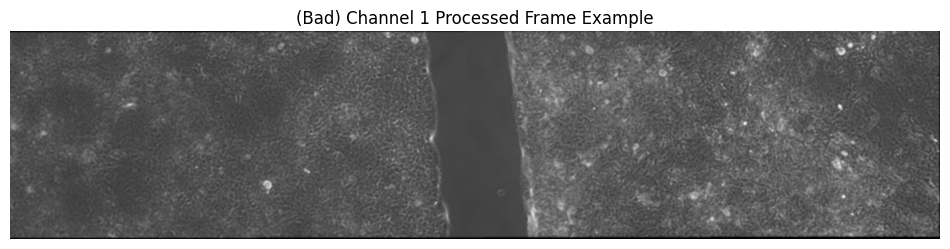

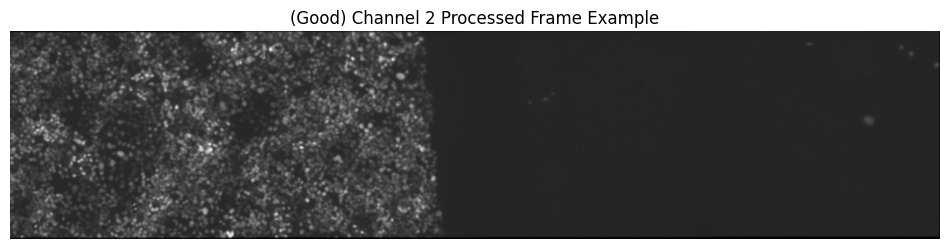

In [6]:
processed_c1_example = preprocess_frame(f1c1)
processed_c2_example = preprocess_frame(f1c2)

show_image(processed_c1_example, title='(Bad) Channel 1 Processed Frame Example')
show_image(processed_c2_example, title='(Good) Channel 2 Processed Frame Example')

## Optical Flow
Now, I'll demonstrate the whole optical flow process. I've made it into one nice little method (function). For a moment, ignore the next cell 6 (the one right below this text).

In [7]:
flow = img.calculate_optical_flow()
flow.shape

(95, 3, 520, 2329, 2)

We can see that the shape of this array is `(95, 3, 520, 2329, 2)` which corresponds to (frames, channels, height, width, derivatives).

The original video has 96 frames, so this one has 95 frames as expected. The derivatives are (dx, dy) and are used to construct the vector field (which I'll show in a second).

The channels sort of correspond to the original video's channels. The second array represents the second channel and the third array represents the third channel. Recall that we didn't use the first channel at all, so the first channel in `flow` is instead the addition of the second and third channels' optical flow. This was a somewhat naive (but effective) attempt at bringing the two channels together to create a holistic picture.

I'll demonstrate below. First, I'll show you the first frame of each channel, so you have a better idea of which corresponds to which.

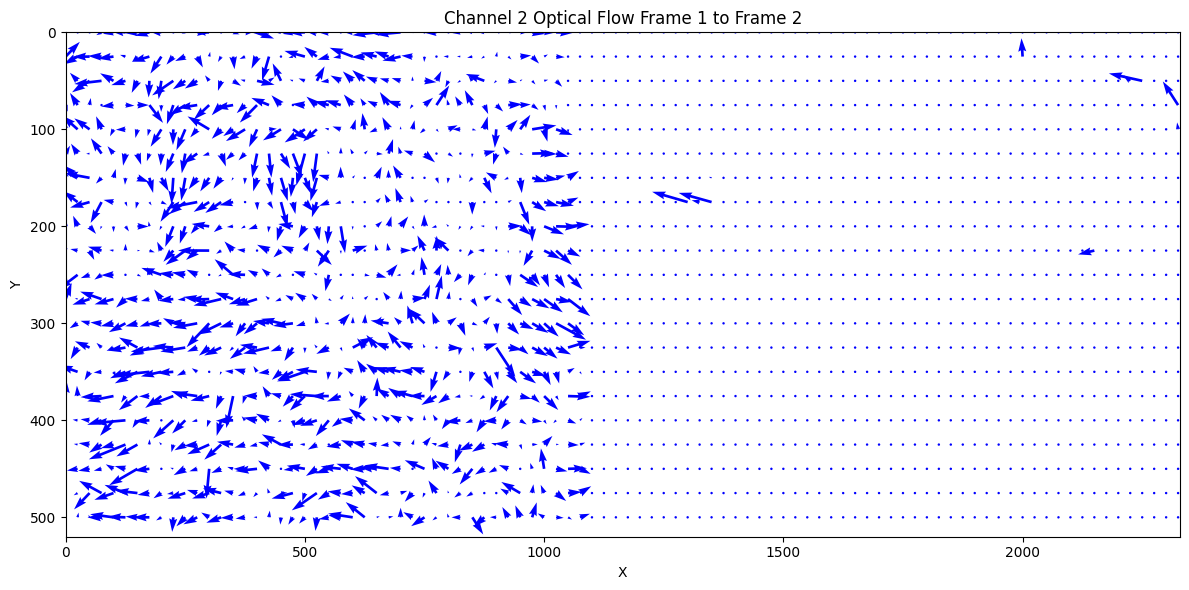

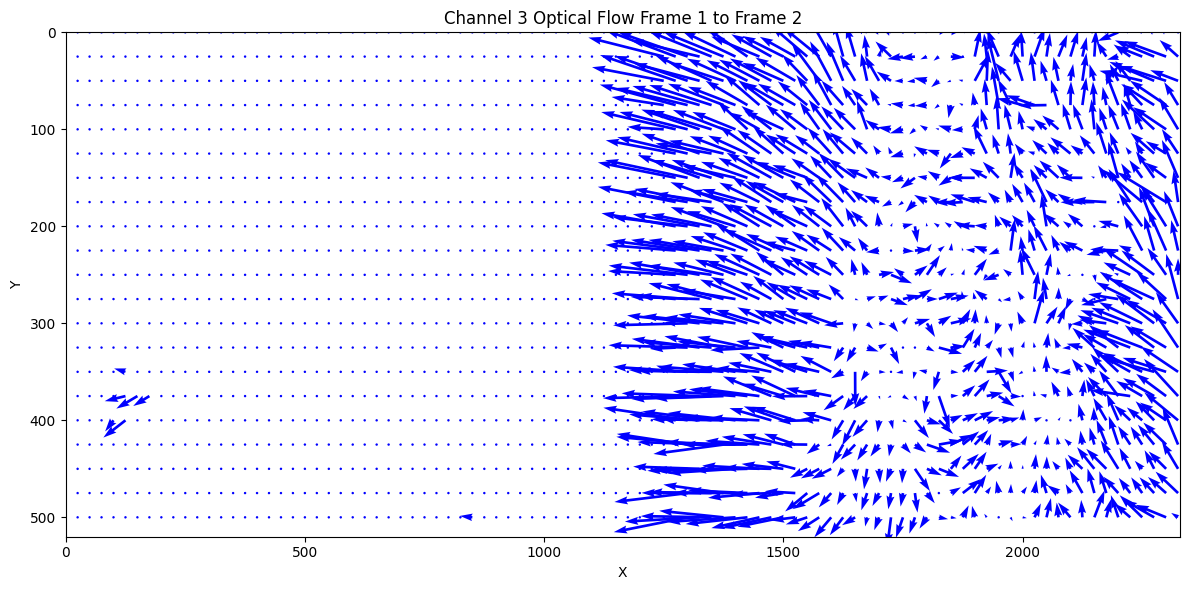

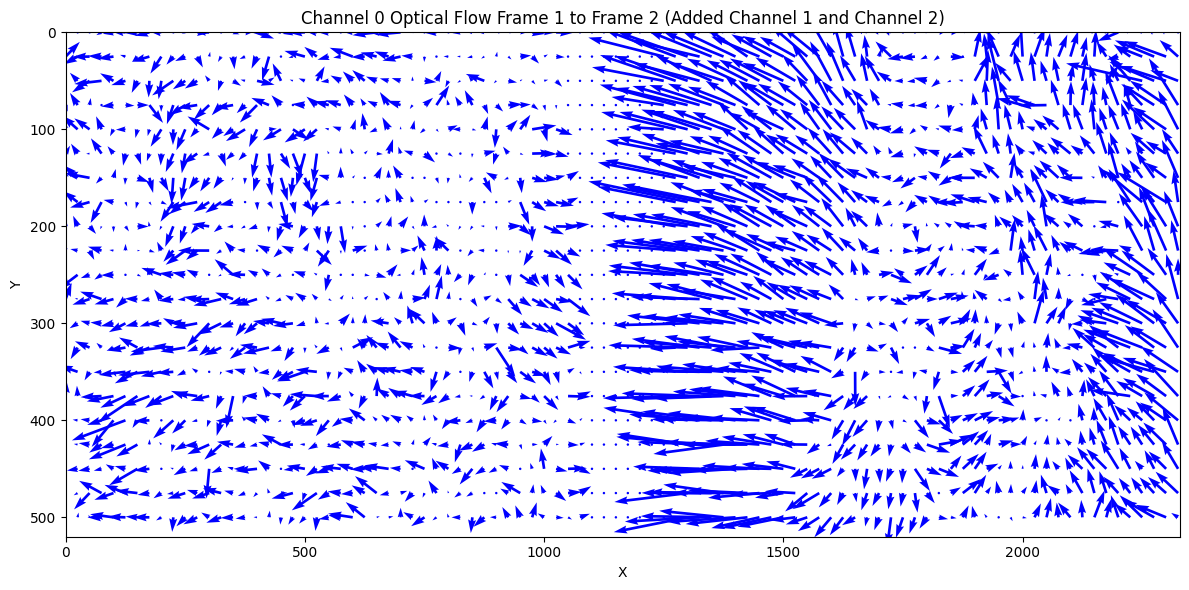

In [8]:
c1_flow = flow[:, 1, :, :]  # Channel 2 optical flow (indexing starts at 0, so channel 2 is index 1)
c2_flow = flow[:, 2, :, :]  # Channel 3 optical flow (the : means all, so we're taking all frames and all pixes in channel 1)
c0_flow = flow[:, 0, :, :]  # Channel 1 + Channel 2 optical flow

show_flow(c1_flow[0], title='Channel 2 Optical Flow Frame 1 to Frame 2')
show_flow(c2_flow[0], title='Channel 3 Optical Flow Frame 1 to Frame 2')
show_flow(c0_flow[0], title='Channel 0 Optical Flow Frame 1 to Frame 2 (Added Channel 1 and Channel 2)')

You can see there is some incorrect extraneous information in the first two channels, but overall they're pretty accurate.

Let's take channel 2 (the first vector field) for example. This is the channel that represents the right-side cells. There are a few vectors on the left-side, located around (400, 175) to (450, 175) that shouldn't be there. If you look at the corresponding spot in channel 3 (the second vector field), you can see that these vectors are roughly the same.

What I realized is that most of channel 2's left-side are zero vectors. So, if you add them to the channel 3's right-side, the right-side vectors won't really change. The right-side vectors in Channel 2 are getting double counted, but there are so many vectors that it doesn't make a huge impact.

We can now do a rough eyeball check. If you're running this notebook, you'll see a directory called 'CellFlow' in your current working directory. After running this next cell, there'll be a video to watch.

In [9]:
img.save_optflow_video(flow)